## Training of non-corrected models

In [1]:
import disentangler as dt
from disentangler.dependencies import *

In [2]:
rna_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_RNA_NO_CORRECTION)
atac_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_ATAC_NO_CORRECTION)

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site

In [3]:
rna_data, atac_data = dt.bonemarrow.utils.load_GEX_data(), dt.bonemarrow.utils.load_ATAC_data()

In [4]:
atac_model.predict(atac_data)
rna_model.predict(rna_data)

Predicting latent vars:   0%|          | 0/263 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


atac_model.get_umap_features(atac_data, box_cox=0.2)
rna_model.get_umap_features(rna_data, box_cox=0.2)

rna_data, atac_data = mira.utils.make_joint_representation(rna_data, atac_data)

In [5]:
shared_cells = np.intersect1d(rna_data.obs_names, atac_data.obs_names)

rna_data, atac_data = rna_data[shared_cells].copy(), atac_data[shared_cells].copy()

atac_data.var[['chr','start','end']] = \
    list(map(list, atac_data.var_names.str.split('-')))

mira.tl.get_distance_to_TSS(atac_data,
                            tss_data = 'data/bonemarrow/hg38_tss_data.bed12.filtered',
                            genome_file= 'data/bonemarrow/hg38.chrom.sizes'
                           )

INFO:mira.tools.connect_genes_peaks:Finding peak intersections with promoters ...
INFO:mira.tools.connect_genes_peaks:Calculating distances between peaks and TSS ...
INFO:mira.tools.connect_genes_peaks:Masking other genes' promoters ...
INFO:mira.adata_interface.rp_model:Added key to var: distance_to_TSS
INFO:mira.adata_interface.rp_model:Added key to uns: distance_to_TSS_genes


In [6]:
from sklearn.model_selection import train_test_split
import os

batch_splits = {}
for i, batch in enumerate(sorted(rna_data.obs.batch.cat.categories)):
    train_bc, test_bc = train_test_split(rna_data[rna_data.obs.batch == batch].obs_names, random_state = i)
    batch_splits[batch] = (train_bc, test_bc)

## Train on subbatches

!rm -rf data/bonemarrow/rp/litemodels_NOBATCH/batches/

In [11]:
!mkdir -p data/bonemarrow/rp/litemodels_NOBATCH/
!mkdir -p data/bonemarrow/rp/litemodels_NOBATCH/batches/

In [23]:
remaining_batches = set(batch_splits.keys())#.difference('s1d1  s1d2  s1d3  s2d1  s2d4  s2d5  s3d10  s3d3  s3d6  s3d7  s4d1'.split('  '))

In [19]:
for batch, (train, test) in {k: v for k, v in batch_splits.items() if k in remaining_batches}.items():
    
    print(batch, len(train), len(test))
    
    litemodel = mira.rp.LITE_Model(
        expr_model=rna_model,
        accessibility_model=atac_model,
        genes=np.intersect1d(rna_model.features, atac_data.uns['distance_to_TSS_genes']),
        counts_layer='counts',
    )
    
    rp_args = dict(
        expr_adata = rna_data[train].copy(),
        atac_adata = atac_data[train].copy()
    )
    

In [22]:
    rna_model._get_softmax_denom(rp_args['expr_adata'], batch_size=500)
    atac_model._get_softmax_denom(rp_args['atac_adata'], batch_size=100)
     
    savedir = os.path.join('data/bonemarrow/rp/litemodels_NOBATCH/batches/', batch)
    
    if not os.path.exists(savedir):
        os.mkdir(savedir)
        
    litemodel.fit(**rp_args, n_workers = 1,
                  callback=mira.rp.SaveCallback(savedir + '/'),
                 )

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/49 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Fitting models:   0%|          | 0/2842 [00:00<?, ?it/s]

## Train on all batches

In [80]:
all_train = set([t for batch, (train, test) in batch_splits.items() for t in train])
all_test = set([t for batch, (train, test) in batch_splits.items() for t in test])

all_train = list(all_train)

len(all_train), len(all_test), len(all_train.intersection(all_test))

litemodel = mira.rp.LITE_Model(
        expr_model=rna_model,
        accessibility_model=atac_model,
        genes=np.intersect1d(rna_model.features, atac_data.uns['distance_to_TSS_genes']),
        counts_layer='counts',
    )
    
rp_args = dict(
    expr_adata = rna_data[all_train].copy(),
    atac_adata = atac_data[all_train].copy()
)

savedir = os.path.join('data/bonemarrow/rp/litemodels_NOBATCH/batches/', 'all')

if not os.path.exists(savedir):
    os.mkdir(savedir)

litemodel.fit(**rp_args, n_workers = 8,
              callback=mira.rp.SaveCallback(savedir + '/'),
             )

## ISD without correction

In [7]:
litemodel = mira.rp.LITE_Model.load_dir(
    expr_model=rna_model,
    accessibility_model=atac_model,
    counts_layer='counts',
    prefix = 'data/bonemarrow/rp/litemodels_NOBATCH/batches/all/'
)

all_train = list(set([t for batch, (train, test) in batch_splits.items() for t in train]))
all_test = list(set([t for batch, (train, test) in batch_splits.items() for t in test]))

rp_args = dict(
    expr_adata = rna_data[all_test].copy(),
    atac_adata = atac_data[all_test].copy()
)

litemodel.predict(**rp_args, n_workers=1)

INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/60 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/60 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2811 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'spans', 'upstream-downstream'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


In [8]:
mira.tl.get_motif_hits_in_peaks(atac_data, genome_fasta='../DataAnalyses/mira-datasets/hg38.fa')

INFO:mira.tools.motif_scan:Getting peak sequences ...
116490it [00:02, 56861.42it/s]
INFO:mira.tools.motif_scan:Scanning peaks for motif hits with p >= 0.0001 ...
INFO:mira.tools.motif_scan:Building motif background models ...
INFO:mira.tools.motif_scan:Starting scan ...
INFO:mira.tools.motif_scan:Found 1000000 motif hits ...
INFO:mira.tools.motif_scan:Found 2000000 motif hits ...
INFO:mira.tools.motif_scan:Found 3000000 motif hits ...
INFO:mira.tools.motif_scan:Found 4000000 motif hits ...
INFO:mira.tools.motif_scan:Found 5000000 motif hits ...
INFO:mira.tools.motif_scan:Found 6000000 motif hits ...
INFO:mira.tools.motif_scan:Found 7000000 motif hits ...
INFO:mira.tools.motif_scan:Found 8000000 motif hits ...
INFO:mira.tools.motif_scan:Found 9000000 motif hits ...
INFO:mira.tools.motif_scan:Found 10000000 motif hits ...
INFO:mira.tools.motif_scan:Found 11000000 motif hits ...
INFO:mira.tools.motif_scan:Found 12000000 motif hits ...
INFO:mira.tools.motif_scan:Found 13000000 motif hits 

In [9]:
rp_args = dict(
    expr_adata = rna_data[all_test].copy(),
    atac_adata = atac_data[all_test].copy()
)

litemodel.probabilistic_isd(**rp_args)

rp_args['expr_adata'].write_h5ad('data/bonemarrow/rp/not_corrected_ISD.h5ad')

INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/60 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/60 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting TF influence:   0%|          | 0/2811 [00:00<?, ?it/s]

INFO:mira.adata_interface.rp_model:Appending to expression adata:
INFO:mira.adata_interface.rp_model:Added key to varm: 'motifs-prob_deletion')
INFO:mira.adata_interface.rp_model:Added key to layers: motifs-informative_samples
INFO:mira.adata_interface.rp_model:Added key to uns: motifs


## Calculating liklihoods on test data

In [7]:
uncalced_batches = [('s4d8', 's1d1'),
 ('s2d5', 's1d2'),
 ('s4d1', 's1d2'),
 ('s2d4', 's1d3'),
 ('s2d5', 's1d3'),
 ('s3d7', 's1d3'),
 ('s4d1', 's1d3'),
 ('s2d5', 's2d4'),
 ('s2d5', 's3d10'),
 ('s2d5', 's3d6'),
 ('s3d10', 's3d7'),
 ('s1d3', 's4d1'),
 ('s2d1', 's4d1'),
 ('s2d4', 's4d1'),
 ('s2d5', 's4d1'),
 ('s3d10', 's4d1'),
 ('s1d1', 's4d8'),
 ('s1d3', 's4d8'),
 ('s2d1', 's4d8'),
 ('s2d4', 's4d8'),
 ('s2d5', 's4d8'),
 ('s3d10', 's4d8'),
 ('s3d3', 's4d8'),
 ('s1d1', 's4d9'),
 ('s1d2', 's4d9'),
 ('s1d3', 's4d9'),
 ('s2d1', 's4d9'),
 ('s2d4', 's4d9'),
 ('s2d5', 's4d9'),
 ('s3d10', 's4d9'),
 ('s3d3', 's4d9'),
 ('s3d6', 's4d9'),
 ('s3d7', 's4d9'),
 ('s4d1', 's4d9'),
 ('s4d8', 's4d9')]

In [8]:
batches = list(batch_splits.keys())

In [9]:
combos = [(train_batch, test_batch) for train_batch in batches + ['all'] for test_batch in batches]

In [10]:
data_likelihoods = {}
model_likelihoods = {}

errors_occurred = {}

for batch, test_batch in uncalced_batches:
    
        try:
            test_set = batch_splits[test_batch][1]

            litemodels = mira.rp.LITE_Model.load_dir(
                    expr_model=rna_model,
                    accessibility_model=atac_model,
                    counts_layer='counts',
                    prefix=os.path.join('data/bonemarrow/rp/litemodels_NOBATCH/batches/', batch + '/')
            )

            rp_args = dict(
                expr_adata = rna_data[test_set].copy(),
                atac_adata = atac_data[test_set].copy()
            )

            rna_model.predict(rp_args['expr_adata'])
            atac_model.predict(rp_args['atac_adata'])

            litemodels.predict(**rp_args, n_workers=1)

            model_likelihoods[(batch, test_batch)] =  rp_args['expr_adata'].varm['LITE_model_logp']
            data_likelihoods[(batch, test_batch)] =  np.squeeze(np.array(rp_args['expr_adata'].layers['LITE_logp'].sum(0)))

            print(batch, test_batch)
        except Exception as err:
            errors_occurred[(batch, test_batch)] = err

Predicting latent vars:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2836 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s4d8 s1d1


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2829 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s2d5 s1d2


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2839 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s4d1 s1d2


Predicting latent vars:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2835 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s2d4 s1d3


Predicting latent vars:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2829 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s2d5 s1d3


Predicting latent vars:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2839 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s3d7 s1d3


Predicting latent vars:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2839 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s4d1 s1d3


Predicting latent vars:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2829 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s2d5 s2d4


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2829 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s2d5 s3d10


Predicting latent vars:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2829 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s2d5 s3d6


Predicting latent vars:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2827 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s3d10 s3d7


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2833 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s1d3 s4d1


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2837 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s2d1 s4d1


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2835 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s2d4 s4d1


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2829 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s2d5 s4d1


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2827 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s3d10 s4d1


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2837 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s1d1 s4d8


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2833 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s1d3 s4d8


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2837 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s2d1 s4d8


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2835 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s2d4 s4d8


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2829 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s2d5 s4d8


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2827 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s3d10 s4d8


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2837 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s3d3 s4d8


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2837 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s1d1 s4d9


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2838 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s1d2 s4d9


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2833 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s1d3 s4d9


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2837 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s2d1 s4d9


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2835 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s2d4 s4d9


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2829 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s2d5 s4d9


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2827 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s3d10 s4d9


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2837 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s3d3 s4d9


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2838 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s3d6 s4d9


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2839 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s3d7 s4d9


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2839 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s4d1 s4d9


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting expression:   0%|          | 0/2836 [00:00<?, ?it/s]

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/pyro/util.py:367: UserWarning: Found plate statements in guide but not model: {'upstream-downstream', 'spans'}
  guide_vars - model_vars
/liulab/alynch/projects/multiomics/BatchEffect/MIRA/mira/rp_model/rp_model.py:837: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(X, requires_grad=False)
INFO:mira.adata_interface.core:Added layer: LITE_prediction
INFO:mira.adata_interface.core:Added layer: LITE_logp


s4d8 s4d9


In [11]:
model_likelihoods.keys()

dict_keys([('s4d8', 's1d1'), ('s2d5', 's1d2'), ('s4d1', 's1d2'), ('s2d4', 's1d3'), ('s2d5', 's1d3'), ('s3d7', 's1d3'), ('s4d1', 's1d3'), ('s2d5', 's2d4'), ('s2d5', 's3d10'), ('s2d5', 's3d6'), ('s3d10', 's3d7'), ('s1d3', 's4d1'), ('s2d1', 's4d1'), ('s2d4', 's4d1'), ('s2d5', 's4d1'), ('s3d10', 's4d1'), ('s1d1', 's4d8'), ('s1d3', 's4d8'), ('s2d1', 's4d8'), ('s2d4', 's4d8'), ('s2d5', 's4d8'), ('s3d10', 's4d8'), ('s3d3', 's4d8'), ('s1d1', 's4d9'), ('s1d2', 's4d9'), ('s1d3', 's4d9'), ('s2d1', 's4d9'), ('s2d4', 's4d9'), ('s2d5', 's4d9'), ('s3d10', 's4d9'), ('s3d3', 's4d9'), ('s3d6', 's4d9'), ('s3d7', 's4d9'), ('s4d1', 's4d9'), ('s4d8', 's4d9')])

In [13]:
import pickle

In [14]:
with open('data/bonemarrow/rp/model_likelihoods.pkl', 'rb') as f:
    ml = pickle.load(f)

with open('data/bonemarrow/rp/data_likelihoods.pkl', 'rb') as f:
    dl = pickle.load(f)

In [18]:
ml.update(model_likelihoods)
dl.update(data_likelihoods)

In [22]:
import pickle
import pandas as pd

In [23]:
with open('data/bonemarrow/rp/model_likelihoods.pkl', 'wb') as f:
    pickle.dump(model_likelihoods, f)

with open('data/bonemarrow/rp/data_likelihoods.pkl', 'wb') as f:
    pickle.dump(data_likelihoods, f)

## With batch prediction

In [1]:
import disentangler as dt
from disentangler.dependencies import *

rna_data, atac_data = dt.bonemarrow.utils.load_GEX_data(), dt.bonemarrow.utils.load_ATAC_data()

In [2]:
rna_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_RNA + '2')
atac_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_ATAC)

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site

In [3]:
atac_model.predict(atac_data)
rna_model.predict(rna_data)

Predicting latent vars:   0%|          | 0/263 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


Predicting latent vars:   0%|          | 0/247 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations


In [4]:
shared_cells = np.intersect1d(rna_data.obs_names, atac_data.obs_names)

rna_data, atac_data = rna_data[shared_cells].copy(), atac_data[shared_cells].copy()

atac_data.var[['chr','start','end']] = \
    list(map(list, atac_data.var_names.str.split('-')))

mira.tl.get_distance_to_TSS(atac_data,
                            tss_data = 'data/bonemarrow/hg38_tss_data.bed12.filtered',
                            genome_file= 'data/bonemarrow/hg38.chrom.sizes'
                           )

INFO:mira.tools.connect_genes_peaks:Finding peak intersections with promoters ...
INFO:mira.tools.connect_genes_peaks:Calculating distances between peaks and TSS ...
INFO:mira.tools.connect_genes_peaks:Masking other genes' promoters ...
INFO:mira.adata_interface.rp_model:Added key to var: distance_to_TSS
INFO:mira.adata_interface.rp_model:Added key to uns: distance_to_TSS_genes


In [5]:
from sklearn.model_selection import train_test_split
import os

batch_splits = {}
for i, batch in enumerate(sorted(rna_data.obs.batch.cat.categories)):
    train_bc, test_bc = train_test_split(rna_data[rna_data.obs.batch == batch].obs_names, random_state = i)
    batch_splits[batch] = (train_bc, test_bc)

In [6]:
all_train = set([t for batch, (train, test) in batch_splits.items() for t in train])
all_test = set([t for batch, (train, test) in batch_splits.items() for t in test])

len(all_train), len(all_test), len(all_train.intersection(all_test))

(45839, 15288, 0)

In [19]:
litemodel = mira.rp.LITE_Model(
        expr_model=rna_model,
        accessibility_model=atac_model,
        genes=np.intersect1d(rna_model.features, atac_data.uns['distance_to_TSS_genes']),
        counts_layer='counts',
    )
    
rp_args = dict(
    expr_adata = rna_data[all_train].copy(),
    atac_adata = atac_data[all_train].copy()
)

savedir = os.path.join('data/bonemarrow/rp/litemodels_NOBATCH/batches/', 'all-corrected')

if not os.path.exists(savedir):
    os.mkdir(savedir)

litemodel.fit(**rp_args, n_workers = 8,
              callback=mira.rp.SaveCallback(savedir + '/'),
             )

In [22]:
!ls data/bonemarrow/rp/litemodels_NOBATCH/batches/all-corrected | wc -l

2841


In [7]:
corrected_litemodel = mira.rp.LITE_Model.load_dir(
    expr_model=rna_model,
    accessibility_model=atac_model,
    counts_layer='counts',
    prefix = 'data/bonemarrow/rp/litemodels_NOBATCH/batches/all-corrected/'
)

all_train = list(set([t for batch, (train, test) in batch_splits.items() for t in train]))
all_test = list(set([t for batch, (train, test) in batch_splits.items() for t in test]))

rp_args = dict(
    expr_adata = rna_data[all_test].copy(),
    atac_adata = atac_data[all_test].copy()
)

corrected_litemodel.predict(**rp_args, n_workers=1)

In [27]:
corrected_model_likelihoods = {}
corrected_data_likelihoods = {}

for test_batch, (train, test) in batch_splits.items():
    
    corrected_model_likelihoods[('corrected-all', test_batch)] =  rp_args['expr_adata'][test].varm['LITE_model_logp']
    corrected_data_likelihoods[('corrected-all', test_batch)] =  np.squeeze(np.array(rp_args['expr_adata'][test].layers['LITE_logp'].sum(0)))

In [17]:
!wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz -O ../DataAnalyses/mira-datasets/hg38.fa.gz

--2022-10-04 19:42:44--  https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘../DataAnalyses/mira-datasets/hg38.fa.gz’

100%[======================================>] 983,659,424 1.71MB/s   in 9m 9s  

2022-10-04 19:51:54 (1.71 MB/s) - ‘../DataAnalyses/mira-datasets/hg38.fa.gz’ saved [983659424/983659424]



In [10]:
mira.tl.get_motif_hits_in_peaks(atac_data, genome_fasta='../DataAnalyses/mira-datasets/hg38.fa')

rp_args = dict(
    expr_adata = rna_data[all_test].copy(),
    atac_adata = atac_data[all_test].copy()
)

corrected_litemodel.probabilistic_isd(**rp_args)

rp_args['expr_adata'].write_h5ad('data/bonemarrow/rp/corrected_ISD.h5ad')

## Analysis

In [28]:
import pickle
import numpy as np
import pandas as pd

In [29]:
with open('data/bonemarrow/rp/model_likelihoods.pkl', 'rb') as f:
    model_likelihoods = pickle.load(f)

with open('data/bonemarrow/rp/data_likelihoods.pkl', 'rb') as f:
    data_likelihoods = pickle.load(f)

In [30]:
model_likelihoods.update(corrected_model_likelihoods)
data_likelihoods.update(corrected_data_likelihoods)

In [31]:
train_batch, test_batch, scores, model_scores = [k[0] for k in data_likelihoods.keys()], \
                                  [k[1] for k in data_likelihoods.keys()], \
                                  [d.sum() for d in data_likelihoods.values()], \
                                  [np.nansum(d) for d in model_likelihoods.values()]

df = pd.DataFrame([train_batch,test_batch,scores, model_scores], index=['train_batch','test_batch','scores','model_scores']).T

len(corrected_litemodel.features)

In [32]:
df['log_likelihood'] = df['scores']/2841# + df['model_scores'])/2841

df['train_batch'] = df.train_batch.str.replace('corrected', ' corrected')

piv = df.pivot(index='train_batch', columns='test_batch', values='log_likelihood')

pivmelt = piv.melt(ignore_index=False).reset_index()

### Likelihood measures

In [33]:
piv

test_batch,s1d1,s1d2,s1d3,s2d1,s2d4,s2d5,s3d10,s3d3,s3d6,s3d7,s4d1,s4d8,s4d9
train_batch,,,,,,,,,,,,,
corrected-all,-438.219354,-465.483761,-288.451707,-325.798385,-360.45012,-316.469917,-518.875332,-263.801668,-119.071294,-97.463658,-332.799329,-373.68127,-157.82286
all,-442.367212,-470.763816,-292.417085,-330.310278,-364.428876,-322.67551,-528.894403,-267.06437,-122.490826,-99.795385,-338.054778,-381.282339,-161.445904
s1d1,-439.526839,-478.073918,-295.064678,-337.317142,-373.042987,-335.214405,-550.467881,-277.823214,-128.460159,-104.123141,-366.25308,-419.834697,-174.906305
s1d2,-454.358017,-463.562742,-293.751628,-348.398165,-396.363164,-331.619368,-561.946542,-284.516015,-129.824831,-105.620116,-373.486096,-417.697554,-176.906767
s1d3,-448.356917,-471.118004,-286.481037,-348.009614,-381.37544,-339.703955,-560.640576,-281.137364,-129.524397,-105.42848,-372.747536,-414.525783,-173.884218
s2d1,-456.626672,-511.13842,-317.624032,-326.490584,-366.097897,-327.330671,-536.99582,-270.689106,-127.90328,-102.50319,-359.016301,-422.028203,-178.605201
s2d4,-474.939106,-541.491904,-332.260296,-339.910947,-354.657251,-346.971115,-547.534011,-274.469971,-128.405073,-103.337315,-356.295583,-427.771779,-178.375902
s2d5,-484.650035,-512.727693,-327.417547,-345.780667,-402.112108,-313.597985,-561.206177,-282.624736,-129.898649,-104.290446,-376.337029,-439.405315,-196.304316
s3d10,-486.148275,-535.821982,-337.360964,-338.296089,-372.090461,-332.967727,-518.397835,-266.799498,-124.567637,-100.405095,-371.965241,-455.729805,-201.057264


In [34]:
order = [' corrected-all', 'all', 's1d1', 's1d2', 's1d3', 's2d4', 's2d5', 's2d1',
       's3d10', 's3d3', 's3d6', 's3d7', 's4d1', 's4d8', 's4d9']

In [35]:
!mkdir -p figure1/RP/

In [36]:
from sklearn.preprocessing import StandardScaler

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(5.5,6), sharex='col',
                       gridspec_kw = dict(width_ratios = [4,1],height_ratios = [4,1]))

sns.heatmap(
    StandardScaler().fit_transform(piv.fillna(piv.min()).loc[order, order[2:]].values),
    ax = ax[0,0],
    #row_colors = [dt.bonemarrow.colors.BATCH_PALETTE[i] if i in dt.bonemarrow.colors.BATCH_PALETTE else 'white' for i in order],
    #col_colors = [dt.bonemarrow.colors.BATCH_PALETTE[i] for i in piv.columns],
    #row_cluster=False, col_cluster = False, square = True,
    #square=True,
    #z_score=1, 
    vmin = -0.5, vmax = 1.5,
    cbar=False,
    cmap = sns.color_palette('Greys', as_cmap=True),
)
ax[0,0].legend([],[], frameon=False)



marginals = (piv.T[' corrected-all'] - piv.T['all']).to_frame(name='corrected_vs_not')
marginals['same_batch_vs_not'] = df[df['train_batch'] == df.test_batch].set_index('train_batch').loc[marginals.index]['log_likelihood'] - piv.T['all']
marginals = marginals.reset_index().reset_index()
marginals['diff'] = marginals['same_batch_vs_not'] - marginals['corrected_vs_not']
marginals['baseline'] = 0

dot = ax[1,0]
for i, row in marginals.iterrows():
    
    dot.plot(
        (i + 0.5,i + 0.5),(row['corrected_vs_not'],row['same_batch_vs_not']),
        c = 'red', alpha = 0.3,
    )
    

marginals['index']+=0.5
sns.scatterplot(
    ax = dot,
    data = marginals.drop(columns = ['diff']).melt(id_vars=['index','test_batch'], var_name='class', value_name='logp'),
    x = 'index',
    y = 'logp',
    hue = 'class',
    palette=['white','black','slategrey'],
    hue_order=['same_batch_vs_not','corrected_vs_not','baseline'],
    #dodge=False,
    s = 50,
    edgecolor = 'black',
    linewidth = 0.5,
)
dot.legend([],[], frameon=False)
dot.set_ymargin(0.2)
sns.despine()
dot.set(ylabel = '',xlabel = '', yticks = [])
dot.set_xticklabels(labels = [])

summary = piv.fillna(piv.min()).sum(axis=1)
summary.name = 'log_likelihood'
summary = summary.to_frame()

summary['delta_likelihood'] = summary['log_likelihood'] - (np.min(summary['log_likelihood']) - 30)


sns.barplot(data=summary.reset_index(), 
             ax=ax[0,1], y = 'train_batch', 
             x = 'delta_likelihood',
             color = 'lightgrey', edgecolor = 'black',linewidth = 1)
             #size = 7)

ax[0,1].set_yticklabels(labels = [])
ax[0,1].set(ylabel = '', xlabel = '')
sns.despine()

ax[1,1].axis('off')
ax[0,0].spines['right'].set_visible(True)
ax[0,0].spines['top'].set_visible(True)
ax[0,0].set_yticklabels(labels = piv.index.values)
plt.tight_layout()
plt.savefig('figure1/RP/total_likelihood.svg')

In [41]:
!realpath figure1/RP/total_likelihood.svg

/liulab/alynch/projects/multiomics/DisentanglerReproduction/figure1/RP/total_likelihood.svg


In [59]:
batches = list(batch_splits.keys())

In [60]:
corrected_gene_logp = (np.vstack([data_likelihoods[('corrected-all',b)] for b in batches]).sum(0) + np.vstack([model_likelihoods[('corrected-all',b)] for b in batches])[0,:])#/rna_data.var.n_cells_by_counts
uncorrected_gene_logp = (np.vstack([data_likelihoods[('all',b)] for b in batches]).sum(0) + np.vstack([model_likelihoods[('all',b)] for b in batches])[0,:])#/rna_data.var.n_cells_by_counts
within_batch_logp = np.vstack([data_likelihoods[(b,b)] for b in batches]).sum(0) + np.vstack([model_likelihoods[(b,b)] for b in batches]).sum(0)

In [61]:
dict(zip(rna_data.var_names, (corrected_gene_logp - uncorrected_gene_logp)/rna_data.var.n_cells_by_counts))['SLC25A37']

0.04155213869493089

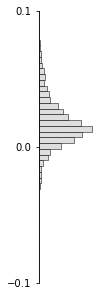

In [62]:
fig, ax = plt.subplots(1,1,figsize=(1,5))
sns.histplot(
    y = (corrected_gene_logp - uncorrected_gene_logp)/rna_data.var.n_cells_by_counts,
    ax = ax,
    color = 'lightgrey',
    bins=100,
    edgecolor = 'black',
    fill='black',
    linewidth = 0.5
)
ax.set(xticks = [], ylim = (-0.1, 0.1),
      xlabel = '', ylabel = '', yticks = [-0.1, 0, 0.1])
for t in ['top','bottom','right']:
    ax.spines[t].set_visible(False)
    
plt.savefig('figure1/RP/RP_likelihood_ratio_nolog.svg')

In [89]:
!realpath figure1/RP/RP_likelihood_ratio_nolog.svg

/liulab/alynch/projects/multiomics/DisentanglerReproduction/figure1/RP/RP_likelihood_ratio_nolog.svg


### Distance measures:

In [292]:
corrected_distances = pd.DataFrame([{'gene' : model.gene, **model.parameters_} for model in corrected_litemodel.models])[['gene','distance_upstream','distance_downstream']]

In [325]:
dframes = []
for batch in batches + ['all']:
    
    litemodels = mira.rp.LITE_Model.load_dir(
                    expr_model=rna_model,
                    accessibility_model=atac_model,
                    counts_layer='counts',
                    prefix=os.path.join('data/bonemarrow/rp/litemodels_NOBATCH/batches/', batch + '/')
            )
    
    dframes.append(
        pd.DataFrame([{'gene' : model.gene, **model.parameters_} for model in litemodels.models])[['gene','distance_upstream','distance_downstream']]
    )

In [334]:
distances = pd.concat([corrected_distances] + dframes, keys= ['corrected'] + batches + ['all']).reset_index().drop(columns = ['level_1'])\
    .rename(columns = {'level_0' : 'batch'})

In [336]:
distances_up, distances_down = distances.drop(columns = ['distance_downstream']), distances.drop(columns = ['distance_upstream'])

In [339]:
distances_up = distances_up.pivot(index = 'gene', columns = 'batch',
                   values = 'distance_upstream')

In [340]:
batch_cols = ['corrected'] + batches + ['all']

In [342]:
distances_up['mean_dist'] = distances_up[batch_cols].mean(1)
distances_up['std_dist'] = distances_up[batch_cols].std(1)

In [346]:
distances_up['dispersion'] = distances_up['std_dist']/distances_up['mean_dist']

In [347]:
distances_up

batch,all,corrected,s1d1,s1d2,s1d3,s2d1,s2d4,s2d5,s3d10,s3d3,s3d6,s3d7,s4d1,s4d8,s4d9,mean_dist,std_dist,dispersion
gene,,,,,,,,,,,,,,,,,,
A2M,30.015533,31.270201,5.710332,4.563600,4.172626,1.543450,6.142056,5.854066,10.902845,3.989770,1.871821,2.141822,3.952744,7.173829,2.399806,8.113633,9.457585,1.165641
A2M-AS1,38.610119,35.385372,29.166302,32.718029,28.704557,29.065769,27.366901,37.155022,45.664143,37.706966,30.774834,39.717342,32.157829,38.763599,27.567327,34.034939,5.443548,0.159940
AASS,20.699059,27.142830,6.125457,8.523370,4.225772,3.883069,3.273750,5.483720,12.006299,2.739124,4.052934,3.642506,4.178671,4.231045,3.833761,7.602758,7.138714,0.938964
ABCA1,201.316681,48.761669,51.570423,46.545231,37.906631,48.549114,22.741913,13.667735,62.345848,41.919693,59.243919,44.333092,93.975136,11.063781,8.613832,52.836979,46.676140,0.883399
ABCA10,39.604950,44.940659,37.936523,35.121212,37.506672,40.292545,37.962482,28.280659,43.525715,31.374346,34.727020,2.829481,47.066055,47.981441,36.429237,36.371933,10.775792,0.296267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN12,30.980898,35.365982,5.697532,11.062675,6.094059,2.032963,3.642443,2.880465,9.182610,18.670856,10.179763,3.256619,18.337526,4.647245,3.186682,11.014554,10.432138,0.947123
ZSCAN16-AS1,13.980625,13.129812,5.480386,4.064608,1.643236,2.759020,2.482336,4.157275,2.607968,4.475950,2.513916,3.674109,2.932908,2.910269,3.731824,4.702950,3.722993,0.791629
ZSCAN30,13.862897,21.574684,2.883743,8.639030,4.033736,5.287654,5.349532,2.456467,7.443970,3.962551,2.674459,3.961910,3.632982,4.506070,2.896948,6.211109,5.186997,0.835116


In [365]:
distances_up = distances_up.drop(columns = ['logp']).join(
    pd.Series(dict(zip(corrected_litemodel.features, corrected_gene_logp)), name = 'logp')
)

In [98]:
len(corrected_litemodel.features)

2841

# ISD analysis

In [2]:
not_corrected = anndata.read_h5ad('data/bonemarrow/rp/not_corrected_ISD.h5ad')
corrected = anndata.read_h5ad('data/bonemarrow/rp/corrected_ISD.h5ad')

In [3]:
rna_model = mira.topics.load_model(dt.bonemarrow.config.MIRA_RNA + '2')

/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/liulab/alynch/projects/batcheffect-env/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


mira.utils.subset_factors(not_corrected, use_factors=not_corrected.var_names)
mira.utils.subset_factors(corrected, use_factors=not_corrected.var_names)

In [283]:
isd_nc = pd.DataFrame(mira.tl.driver_TF_test(not_corrected, geneset=rna_model.get_top_genes(3,200)))
isd = pd.DataFrame(mira.tl.driver_TF_test(corrected, geneset=rna_model.get_top_genes(3,200)))
isd_results = isd_nc.set_index('id').join(isd.set_index('id')['pval'], lsuffix='_notcorrected')

INFO:mira.tools.tf_targeting:Testing with 162 query genes and 2649 background genes, against 1646 factors


Testing factors:   0%|          | 0/1646 [00:00<?, ?it/s]

INFO:mira.tools.tf_targeting:Testing with 162 query genes and 2679 background genes, against 1646 factors


Testing factors:   0%|          | 0/1646 [00:00<?, ?it/s]

In [284]:
isd_results = isd_results[isd_results.parsed_name.isin(rna_data.var_names)]

In [285]:
isd_results['corrected_significant'] = isd_results.pval < (0.05/len(isd_results))
isd_results['notcorrected_significant'] = isd_results.pval_notcorrected < (0.05/len(isd_results))
isd_results.sort_values('pval').head(20)

,name,parsed_name,pval_notcorrected,test_statistic,pval,corrected_significant,notcorrected_significant
id,,,,,,,
MA0140.2,GATA1::TAL1,GATA1,4.618428e-10,275956.0,1.612019e-14,True,True
MA0035.4,GATA1,GATA1,3.292210e-03,241812.0,1.015366e-05,True,False
MA0036.3,GATA2,GATA2,5.758575e-04,247165.0,1.386494e-05,True,False
MA0091.1,TAL1::TCF3,TAL1,3.024109e-02,233393.0,2.149880e-05,True,False
MA0037.3,GATA3,GATA3,1.567771e-03,244189.0,4.909124e-05,True,False
MA1124.1,ZNF24,ZNF24,2.196316e-02,234773.5,1.787666e-04,False,False
MA0729.1,RARA,RARA,1.089951e-03,245298.0,2.577278e-04,False,False
MA0025.2,NFIL3,NFIL3,1.487316e-01,225017.0,5.228701e-04,False,False
MA1702.1,PDP1,PDP1,4.001175e-02,232123.0,8.467387e-04,False,False


In [286]:
isd_results.set_index('parsed_name').loc['KLF1']

name                            KLF1
pval_notcorrected           0.050631
test_statistic              231003.0
pval                         0.16381
corrected_significant          False
notcorrected_significant       False
Name: KLF1, dtype: object

In [310]:
-np.log10(isd_results[isd_results.corrected_significant & ~isd_results.notcorrected_significant].sort_values('pval').set_index('name').pval)

name
GATA1         4.993377
GATA2         4.858082
TAL1::TCF3    4.667586
GATA3         4.308996
Name: pval, dtype: float64

In [288]:
isd_results[isd_results.notcorrected_significant & ~isd_results.corrected_significant]

,name,parsed_name,pval_notcorrected,test_statistic,pval,corrected_significant,notcorrected_significant
id,,,,,,,


In [289]:
isd_results['pval_diff'] = np.log10(isd_results['pval']) - np.log10(isd_results['pval_notcorrected'])
isd_results[isd_results.pval < 1e-2].sort_values('pval_diff').head(20)

,name,parsed_name,pval_notcorrected,test_statistic,pval,corrected_significant,notcorrected_significant,pval_diff
id,,,,,,,,
MA0140.2,GATA1::TAL1,GATA1,4.618428e-10,275956.0,1.612019e-14,True,True,-4.457124
MA0091.1,TAL1::TCF3,TAL1,3.024109e-02,233393.0,2.149880e-05,True,False,-3.148183
MA0035.4,GATA1,GATA1,3.292210e-03,241812.0,1.015366e-05,True,False,-2.510865
MA0025.2,NFIL3,NFIL3,1.487316e-01,225017.0,5.228701e-04,False,False,-2.454009
MA1124.1,ZNF24,ZNF24,2.196316e-02,234773.5,1.787666e-04,False,False,-2.089408
MA1702.1,PDP1,PDP1,4.001175e-02,232123.0,8.467387e-04,False,False,-1.674438
MA0036.3,GATA2,GATA2,5.758575e-04,247165.0,1.386494e-05,True,False,-1.618397
MA1579.1,ZBTB26,ZBTB26,3.776791e-01,217694.0,9.263034e-03,False,False,-1.610370
MA0043.3,HLF,HLF,1.117334e-01,226776.0,3.493504e-03,False,False,-1.504922


In [290]:
isd_results['significant'] = isd_results.notcorrected_significant | isd_results.corrected_significant

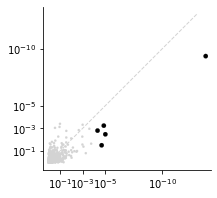

In [307]:
fig, ax = plt.subplots(1,1,figsize=(3,3))

sns.lineplot(
    x = [1,1e-13],y =[1, 1e-13],
    dashes = True,
    color= 'lightgrey',
    linewidth = 1.,
    linestyle='--'
)


sns.scatterplot(
    ax = ax,
    data = isd_results,
    x = 'pval',
    y = 'pval_notcorrected',
    hue = 'significant',
    palette=['lightgrey','black',],
    size = 'corrected_significant',
    sizes=[5,20],
    legend=False,
    edgecolor= None,
)



sns.despine()
ax.axis('equal')
ax.set_aspect('equal')
ax.invert_xaxis()
ax.invert_yaxis()
ax.set(yscale = 'log', xscale = 'log', xlabel = '', ylabel = '',
      xticks = [0.1, 0.001, 0.00001, 0.0000000001],
      yticks = [0.1, 0.001, 0.00001, 0.0000000001])

plt.savefig('figure1/RP/isd_pryoerythroblast_comparison.svg', dpi = 300, bbox_inches = 'tight')

In [303]:
!realpath figure1/RP/isd_pryoerythroblast_comparison.png

/liulab/alynch/projects/multiomics/DisentanglerReproduction/figure1/RP/isd_pryoerythroblast_comparison.png


In [293]:
from mira.plots.base import map_plot, plot_umap, map_colors

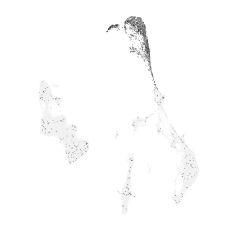

In [314]:
def topic_umap(ax, topic):
    
    ax = plot_umap(
        rna_data.obsm['X_umap'],
        rna_data.obs_vector(topic),
        palette=sns.color_palette('light:black', as_cmap=True),
        figsize=(5,5),
        size = 0.5,
        add_legend=False,
        ax = ax,
        title = None,#'Topic ' + topic.split('_')[-1],
        edgecolor = None,
        linewidth = 0.
    )
    ax.set_xmargin(0.2)
    ax.set_xmargin(0.2)

fig, ax=plt.subplots(1,1,figsize=(4,4))
topic_umap(ax, 'GATA1')
#plt.savefig('figure1/RP/TAL1_expression.png', bbox_inches = 'tight', dpi = 300)

In [326]:
print(*rna_data.obs.cell_type.unique())

Naive CD20+ B CD14+ Mono CD8+ T CD16+ Mono B1 B Lymph prog CD4+ T naive CD4+ T activated Erythroblast NK Transitional B ILC Normoblast G/M prog MK/E prog HSC pDC ID2-hi myeloid prog Proerythroblast Plasma cell cDC2 CD8+ T naive


In [335]:
rna_data.obs['celltypes_of_interest'] = np.where(
    rna_data.obs.cell_type.isin(['Erythroblast','Normoblast','Proerythroblast','MK/E prog','HSC']),
    rna_data.obs.cell_type.values,
    'Other'
)

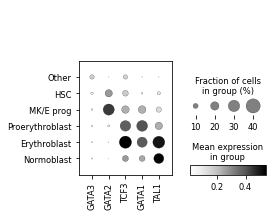

In [342]:
sc.pl.dotplot(rna_data, 
              ['GATA3','GATA2','TCF3','GATA1','TAL1',],
              groupby='celltypes_of_interest',
              cmap='Greys',
              show=False,
              categories_order = ['Normoblast','Erythroblast','Proerythroblast','MK/E prog','HSC','Other',][::-1]
             )
plt.savefig('figure1/RP/TF_expression.svg')

In [79]:
rna_data = dt.bonemarrow.utils.load_GEX_data()

rna_model.predict(rna_data)

rna_model.get_umap_features(rna_data, box_cox=0.1)

sc.pp.neighbors(rna_data, use_rep = 'X_umap_features', metric = 'manhattan')
sc.tl.umap(rna_data, min_dist = 0.1, negative_sample_rate = 3)

umap_coors = rna_data.obsm['X_umap'].copy()

del rna_data

from disentangler.bonemarrow import config

data = sc.read_h5ad(config.RAW_DATA)
rna_data = data[:, data.var.feature_types == 'GEX'].copy()
del data
sc.pp.calculate_qc_metrics(rna_data, inplace=True, log1p=False)

sc.pp.filter_cells(rna_data, min_genes = 400)
sc.pp.filter_genes(rna_data, min_cells=30)
sc.pp.normalize_total(rna_data, target_sum=1e4)
sc.pp.log1p(rna_data)

sc.pp.highly_variable_genes(rna_data, min_disp= 0.3)
rna_data.var['exog'] = rna_data.var.highly_variable.copy()

rna_data.obsm['X_umap'] = umap_coors.copy()